In [7]:
import pandas as pd
import mne
import numpy as np

# 1. Ruta del archivo
fname = r"C:\Users\RODRIGO\Downloads\BrainFlow-RAW_2025-09-17_12-36-58_20.csv"

# 2. Leer el archivo OpenBCI
# - comment='%' → ignora líneas que empiezan con %
# - engine='python' + sep=None → detecta si usa coma, tab o espacios
df = pd.read_csv(
    fname,
    comment='%',
    sep=None,
    engine='python'
)

# 3. A veces OpenBCI pone una fila con texto (Sample Index...). Vamos a forzar a numérico.
#    errors='coerce' convierte lo que no es número en NaN
df = df.apply(pd.to_numeric, errors='coerce')

# 4. Quitar columnas que quedaron totalmente vacías o filas que son solo NaN
df = df.dropna(axis=1, how='all')
df = df.dropna(axis=0, how='all')

# Ahora df debería ser puro número

# 5. Elegimos cuántos canales EEG queremos.
#    Supongamos que tus primeros 8 canales son EEG. Si usaste 4, cambia a range(4).
n_eeg = 8
# Si el archivo tiene menos columnas que eso, ajustamos
n_eeg = min(n_eeg, df.shape[1])

eeg_idx = list(range(n_eeg))
data = df.iloc[:, eeg_idx].to_numpy().T   # (n_channels, n_samples)

# 6. Crear nombres de canal
ch_names = [f"EEG{i+1}" for i in range(n_eeg)]

# 7. Frecuencia de muestreo (ajusta si no es 250 Hz)
sfreq = 250.0

# 8. Crear info y Raw
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
raw = mne.io.RawArray(data, info)

# 9. Recortar (si tu señal dura menos de 30 s, baja este valor)
raw.crop(tmin=0, tmax=30)

# 10. Filtrar como en tu código original
raw.load_data()
raw.filter(l_freq=1.0, h_freq=None)

# 11. Mantener EEG
raw.pick(picks="eeg", exclude="bads")

print(raw)
from mne.preprocessing import ICA

# 1. Crear el objeto ICA
#    Usa 8 componentes (tantos como canales EEG que tienes)
n_components = len(raw.info["ch_names"])

ica = ICA(
    n_components=n_components,   # igual que número de canales
    method="picard",             # algoritmo ICA
    max_iter="auto",             # parar automáticamente cuando converge
    random_state=97              # resultado reproducible
)

# 2. Ajustar ICA a tus datos EEG
print("⚙️ Ejecutando ICA, esto puede tardar unos segundos...")
ica.fit(raw)

print(" ICA completado. Puedes visualizar los componentes así:")
print("   ica.plot_components()   # muestra mapas espaciales")
print("   ica.plot_sources(raw)   # muestra señales temporales")

Creating RawArray with float64 data, n_channels=8, n_times=180279
    Range : 0 ... 180278 =      0.000 ...   721.112 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)

<RawArray | 8 x 7501 (30.0 s), ~479 KiB, data loaded>
⚙️ Ejecutando ICA, esto puede tardar unos segundos...
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.1s.
 ICA completado. Puedes visualizar los componentes así:
   ica.plot_components()   # muestra mapas espaciales
   ica.plot_sources(raw)   # muestra señales temporales


In [8]:
ica.plot_sources(raw)

Creating RawArray with float64 data, n_channels=8, n_times=7501
    Range : 0 ... 7500 =      0.000 ...    30.000 secs
Ready.


<mne_qt_browser._pg_figure.MNEQtBrowser(0x2d5787db370) at 0x000002D5A3AD7CC0>

![Señal](https://github.com/Kumiho-17/GRUPO-04-ISB-2025-II/blob/master/Images/Captura%20de%20pantalla%202025-11-05%20125719.png?raw=true)


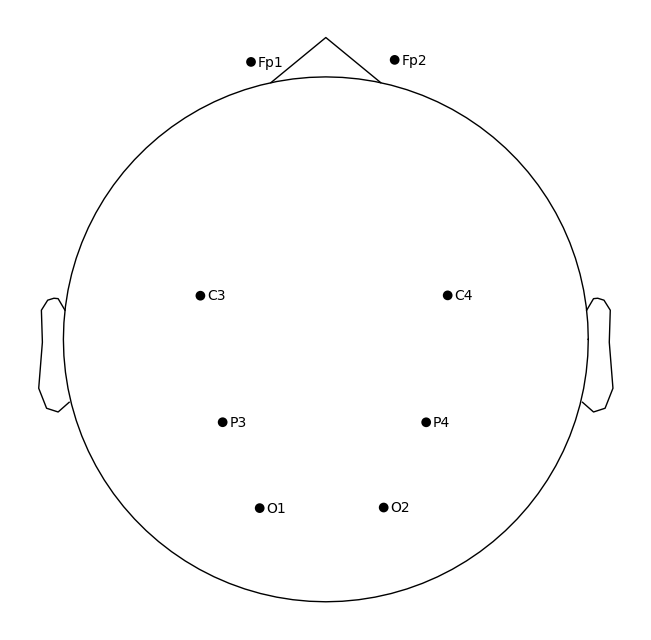

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.1s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline co

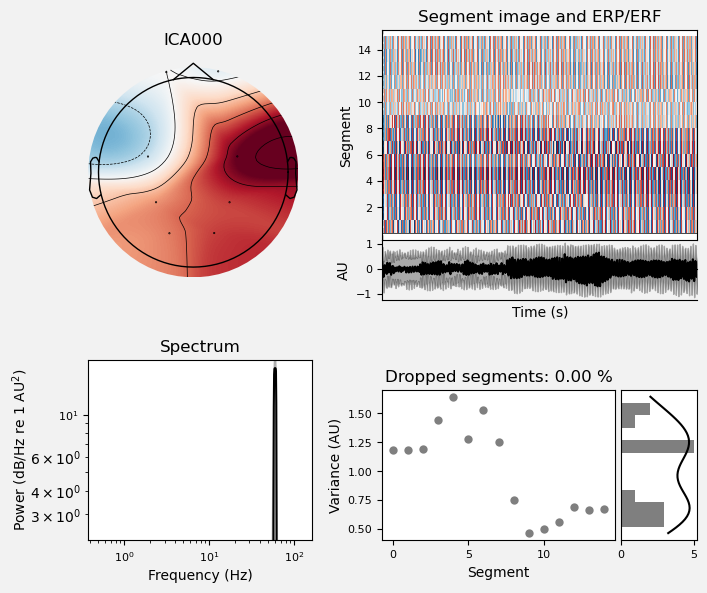

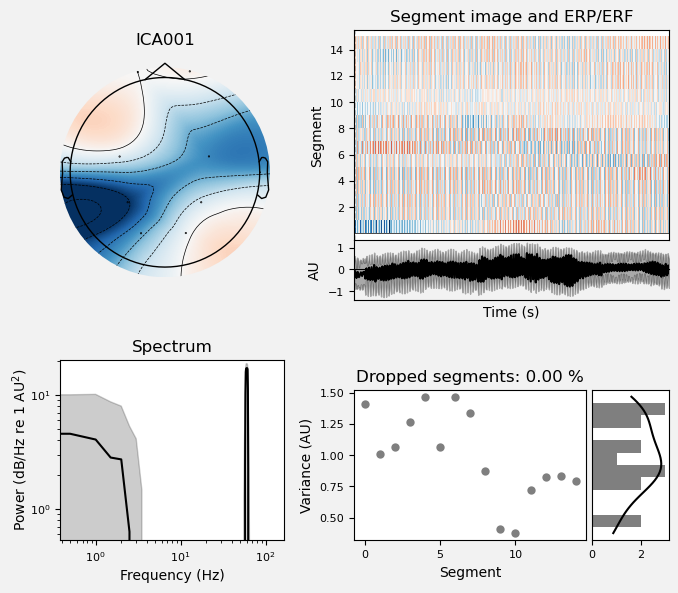

c:\Users\RODRIGO\mne-python\1.10.2_0\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


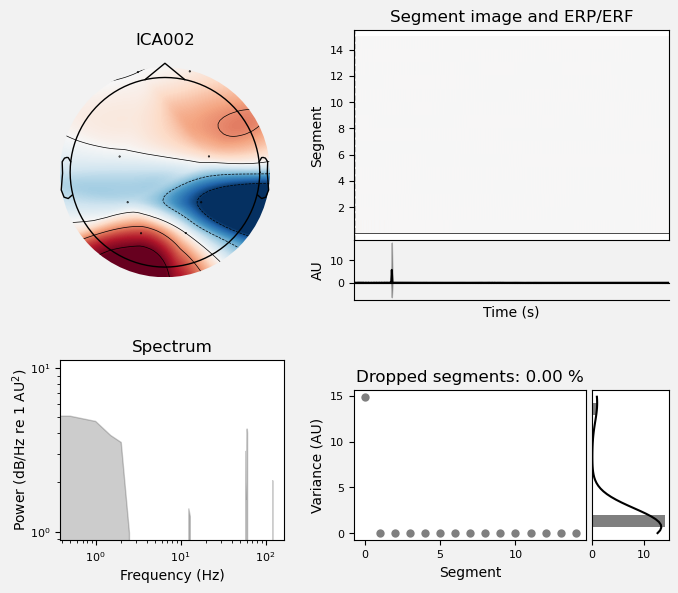

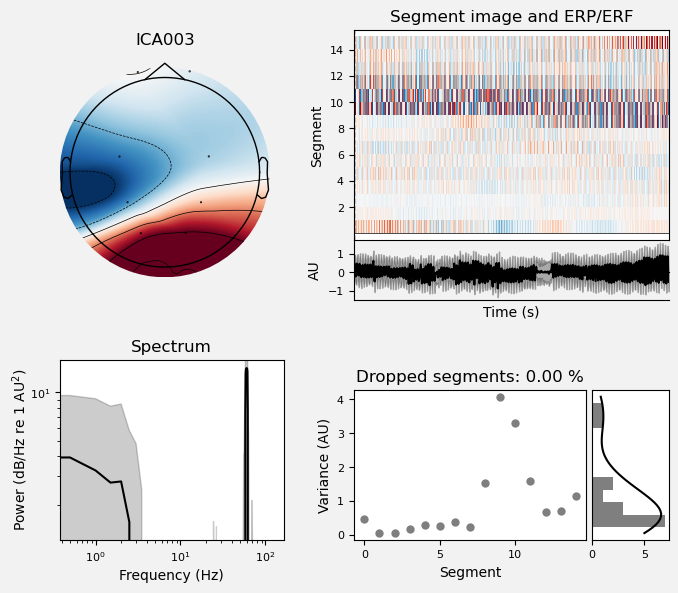

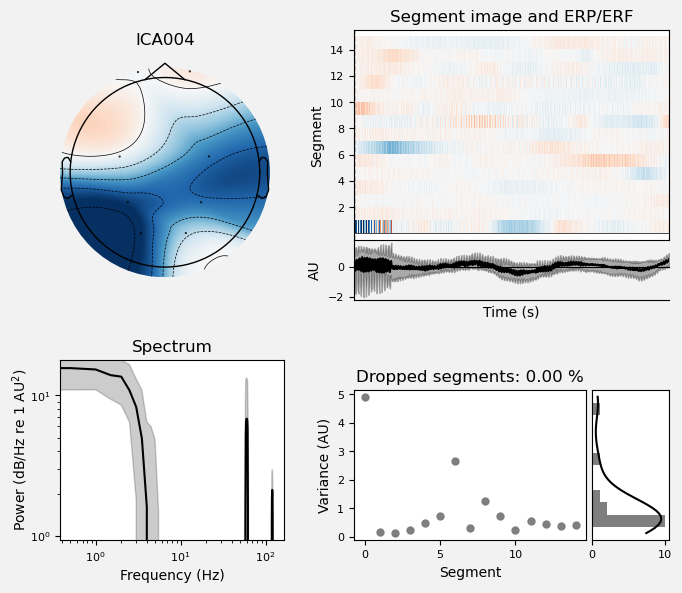

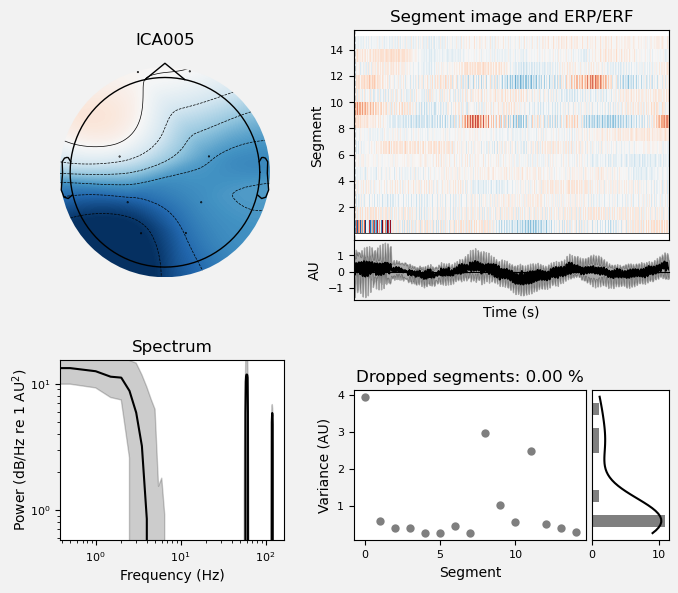

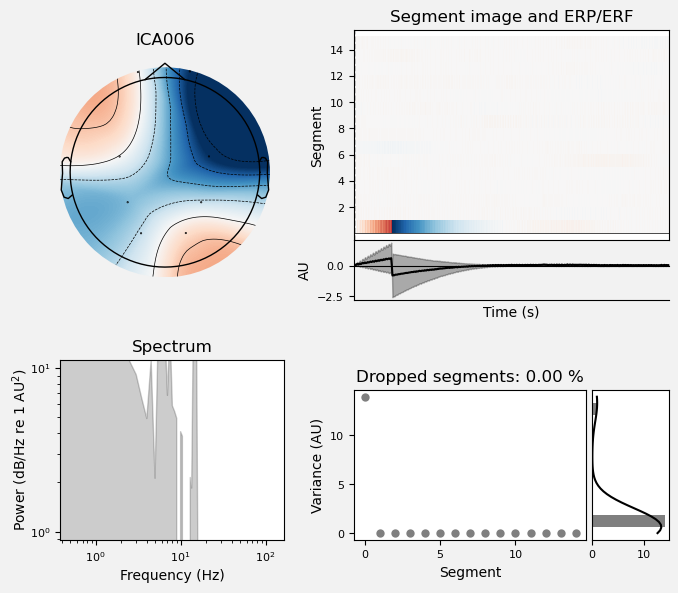

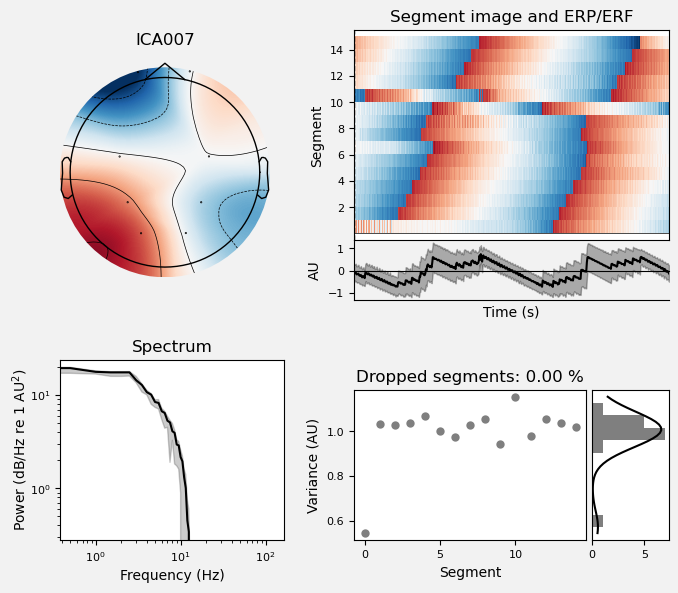

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [9]:
# Ejemplo de renombrado si tienes 8 canales genéricos: 
raw.rename_channels({ 'EEG1': 'Fp1', 'EEG2': 'Fp2', 'EEG3': 'C3', 'EEG4': 'C4', 'EEG5': 'P3', 'EEG6': 'P4', 'EEG7': 'O1', 'EEG8': 'O2' }) 
raw.set_montage("standard_1020") # Asignar montaje estándar 10-20
montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage) # Visualizar sensores 
raw.plot_sensors(show_names=True) # Ajustar ICA (asegúrate de n_components <= número de canales) 
ica = mne.preprocessing.ICA(n_components=8, method="picard", max_iter="auto", random_state=97)
ica.fit(raw) # Graficar propiedades de los componentes ICA 
idx = list(range(ica.n_components_)) # Índices de los componentes ICA 
ica.plot_properties(raw, picks=idx, log_scale=True)

In [10]:
ica.plot_overlay(raw, exclude=muscle_idx)

NameError: name 'muscle_idx' is not defined

Effective window size : 8.192 (s)


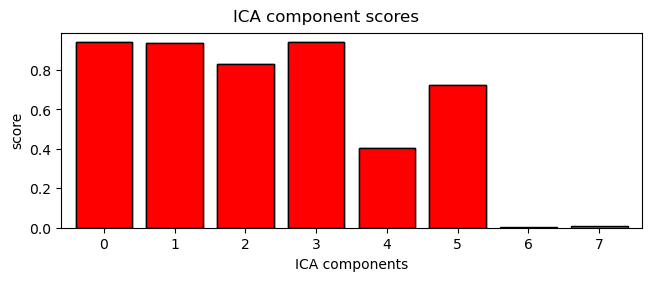

Manually found muscle artifact ICA components:      [0, 1, 3]
Automatically found muscle artifact ICA components: [0, 1, 2, 3, 4, 5]


In [ ]:
muscle_idx_auto, scores = ica.find_bads_muscle(raw)
ica.plot_scores(scores, exclude=muscle_idx_auto)
print(
    f"Manually found muscle artifact ICA components:      {muscle_idx}\n"
    f"Automatically found muscle artifact ICA components: {muscle_idx_auto}"
)

In [ ]:

import mne



bad_components = [0,1,3]  

# Elimina los componentes de la señal
ica.exclude = bad_components
raw_reconstructed = raw.copy()
ica.apply(raw_reconstructed)

# Graficar señal original y reconstruida para comparar
raw.plot(title='Señal original', block=True)
raw_reconstructed.plot(title='Señal reconstruida (componentes eliminados)')



Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 3 ICA components
    Projecting back using 8 PCA components
Channels marked as bad:
none


<mne_qt_browser._pg_figure.MNEQtBrowser(0x1a321ae8460) at 0x000001A31E58C500>